# Prediction of river flow using RNN with LSTM architecture

In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
# from tensorflow.nn import dynamic_rnn
from tensorflow.python.tools import inspect_checkpoint as chkp # import the inspect_checkpoint library
# import tensorboard as tb
import numpy as np
import scipy.io as sio # for working with .mat files
# import pandas as pd # for working with .xlsx files
from openpyxl import load_workbook # for working with .xlsx files
import matplotlib.pyplot as plt # for plotting the data
from datetime import datetime # for keeping separate TB logs for each run
import os, sys
import textwrap
import time # for measuring time cost
from collections import namedtuple

C:\Users\Martin\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# define net parameters
class params:
    # initialization of instance variables
    def __init__(self,n_lstm_layers=2,hidden_size=10,delay=10,pred_step=1,train_batch_size=5,test_batch_size=5,val_batch_size=5,n_epochs=100,stop_epochs=20,check_every=10,init_lr=0.001,n_repeats=1,dropout=False,input_keepProb=1,output_keepProb=1,recurrent_keepProb=1):
        self.input_size = 1 # number of input features (we only follow one variable == flow)
        self.num_classes = 1 # number of output classes (we wan't specific value, not classes, so this is 1)
        self.target_shift = 1 # the target is the same time-series shifted by 1 time-step forward
        self.n_lstm_layers = n_lstm_layers # number of vertically stacked LSTM layers
        self.hidden_size = hidden_size # hidden state vector size in LSTM cell
        self.delay = delay # the number of time-steps from which we are going to predict the next step
        self.pred_step = pred_step # the number of time-steps we predict into the future (1 == One-step prediction ; >1 == Multi-step prediction)
        self.train_batch_size = train_batch_size # number of inputs in one training batch
        self.test_batch_size = test_batch_size # number of inputs in one testing batch
        self.val_batch_size = val_batch_size # number of inputs in one validation batch
        self.n_epochs = n_epochs # number of epochs
        self.stop_epochs = stop_epochs # if the loss value doesn't improve over the last stop_epochs, the training process will stop
        self.check_every = check_every # how often to check for loss value in early stopping
        self.init_lr = init_lr # initial learning rate for Adam optimizer (training algorithm)
        self.n_repeats = n_repeats # number of repeats of the whole training and validation process with the same params
        self.net_unroll_size = self.delay + self.pred_step - 1 # number of unrolled LSTM time-step cells
        # FIGHTING OVERFITTING:
        self.dropout = dropout # if true the dropout is applied on inputs, outputs and recurrent states of cells
        self.input_keepProb = input_keepProb # (dropout) probability of keeping the input
        self.output_keepProb = output_keepProb # (dropout) probability of keeping the output
        self.recurrent_keepProb = recurrent_keepProb # (dropout) probability of keeping the recurrent state
    
    # representation of object for interpreter and debugging purposes
    def __repr__(self):
        return '''params(n_lstm_layers={:d},hidden_size={:d},delay={:d},pred_step={:d},\
train_batch_size={:d},test_batch_size={:d},val_batch_size={:d},n_epochs={:d},stop_epochs={:d},check_every={:d},init_lr={:f},dropout={},\
n_repeats={:d},input_keepProb={:f},output_keepProb={:f},recurrent_keepProb={:f})'''.format(self.n_lstm_layers,
                                                                            self.hidden_size,
                                                                            self.delay,
                                                                            self.pred_step,
                                                                            self.train_batch_size,
                                                                            self.test_batch_size,
                                                                            self.val_batch_size,
                                                                            self.n_epochs,
                                                                            self.stop_epochs,
                                                                            self.check_every,
                                                                            self.init_lr,
                                                                            self.n_repeats,
                                                                            self.dropout,
                                                                            self.input_keepProb,
                                                                            self.output_keepProb,
                                                                            self.recurrent_keepProb)
    
    # how will the class object be represented in string form (eg. when called with print())
    def __str__(self):
        answer = '''
Input size ...................... {:4d}
Number of classes ............... {:4d}
Target shift .................... {:4d}
Number of stacked LSTM layers ... {:4d}
Hidden state size ............... {:4d}
Delay ........................... {:4d}
Number of prediciton steps....... {:4d}
Training batch size ............. {:4d}
Testing batch size .............. {:4d}
Validation batch size ........... {:4d}
Maximum number of epochs ........ {:4d}
Early stopping epochs ........... {:4d}
Check (save) every (epochs)...... {:4d}
Initial learning rate ........... {:9.4f}
Dropout ......................... {}'''.format(self.input_size
                                              ,self.num_classes
                                              ,self.target_shift
                                              ,self.n_lstm_layers
                                              ,self.hidden_size
                                              ,self.delay
                                              ,self.pred_step
                                              ,self.train_batch_size
                                              ,self.test_batch_size
                                              ,self.val_batch_size
                                              ,self.n_epochs
                                              ,self.stop_epochs
                                              ,self.check_every
                                              ,self.init_lr
                                              ,self.dropout)
        
        dropout_answer = '''
Input keep probability .......... {:7.2f}
Output keep probability ......... {:7.2f}
Recurrent keep probability ...... {:7.2f}'''.format(self.input_keepProb
                                                 ,self.output_keepProb
                                                 ,self.recurrent_keepProb)
        
        if self.dropout:
            return answer + dropout_answer
        else:
            return answer

# net and training parameter specification
par = params(n_lstm_layers = 2
            ,hidden_size = 4
            ,delay = 8
            ,pred_step = 5
            ,train_batch_size=16 # (https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/)
            ,test_batch_size=8
            ,val_batch_size=4
            ,n_epochs=100
            ,stop_epochs=20 # if <= 0 then early stopping is disabled and check every sets the saving period
            ,check_every=10
            ,init_lr=0.001
            ,n_repeats=1
            ,dropout=False
            ,input_keepProb=1.0
            ,output_keepProb=1.0
            ,recurrent_keepProb=1.0)
    

# enable/disable L2 regularization
regularization = False # NOT IMPLEMENTED YET (go to: https://stackoverflow.com/questions/37869744/tensorflow-lstm-regularization)

# continue training the model with saved variables from previeous training
continueLearning = False

# decaying learning rate constants (for exponential decay)
# Adam already has adaptive learning rate for individual weights 
# but it can be combined with decaying learning rate for faster convergence
decay_steps = par.n_epochs//10 # every "n_epochs//10" epochs the learning rate is reduced
decay_rate = 1 # the base of the exponential (rate of the decay ... 1 == no decay)

# deciding which device (CPU/GPU) should be used for tf operations
use_gpu = False
if use_gpu:
    device = "/gpu:0"
else:
    device = "/cpu:0"

In [3]:
print(par)


Input size ......................    1
Number of classes ...............    1
Target shift ....................    1
Number of stacked LSTM layers ...    2
Hidden state size ...............    4
Delay ...........................    8
Number of prediciton steps.......    5
Training batch size .............   16
Testing batch size ..............    8
Validation batch size ...........    4
Maximum number of epochs ........  100
Early stopping epochs ...........   20
Check (save) every (epochs)......   10
Initial learning rate ...........    0.0010
Dropout ......................... False


In [4]:
# select input data for the network
# 1) ... Weekly Elbe flow (normalized)
# 2) ... Daily Saugeen flow (unknown)
selected_data = 1

### 1) DATA from prof. A. Procházka:
* **url:**: http://uprt.vscht.cz/prochazka/pedag/Data/dataNN.zip
* **name**: Weekly Elbe river flow
* **Provider source:** Prof. Ing. Aleš Procházka, CSc
* **Span:** 313 weeks ~ 6 years of data
* **Data size:** 313 values
* **Already normalized** to 0 mean and 1 variance

In [5]:
if selected_data == 1:
    # load data from Q.mat
    filename = './datasets/Q.MAT'
    data = sio.loadmat(filename) # samples were gathered with period of one week

    # convert to np array
    data = np.array(data['Q'],dtype=np.float32)

    print(np.shape(data))

    # normalize the data to interval (0,1)
    min_data = np.min(data)
    max_data = np.max(data)
    # shift the data to start at 0.001 (for relative error counting purposes)
#    data = np.subtract(data,min_data)+0.001
    # data = np.divide(np.subtract(data,min_data),np.subtract(max_data,min_data)).flatten()
    # normalize the data to interval (-1,1) (cca 0 mean and 1 variance)
    mean_data = np.mean(data) # mean
    std_data = np.std(data) # standard deviation
    data = np.divide(np.subtract(data,mean_data),std_data).flatten()

    # divide the data into training, testing and validation part
    weeks_in_year = 52.1775
    years_in_data = 313/weeks_in_year

    years_in_train = int(years_in_data*0.7) # 70% of data rounded to the number of years
    years_in_test = int(np.ceil(years_in_data*0.15)) # 15% of data rounded to the number of years

    weeks_train = int(years_in_train*weeks_in_year) # number of weeks in training data
    weeks_test = int(years_in_test*weeks_in_year) # number of weeks in testing data

    end_of_train = weeks_train
    end_of_test = weeks_train + weeks_test

    x_train = data[:end_of_train]
    x_test = data[end_of_train:end_of_test]
    x_validation = data[end_of_test:]

    plot_start = 0
    plot_end = -1

(1, 313)


### 2) DATA from Time Series Data Library:
* **url:** https://datamarket.com/data/set/235a/mean-daily-saugeen-river-flows-jan-01-1915-to-dec-31-1979#!ds=235a&display=line
* **name:** Mean daily Saugeen River (Canada) flows
* **Provider source:** Hipel and McLeod (1994)
* **Span:** Jan 01, 1915 to Dec 31, 1979
* **Data size:** 23741 values

In [6]:
if selected_data == 2:
    # load excel spreadsheet with openpyxl:
    filename = './datasets/sugeen-river-flows.xlsx'
    xl = load_workbook(filename)

    # print sheet names:
    print(xl.get_sheet_names())

    # get sheet:
    sheet = xl.get_sheet_by_name('Mean daily saugeen River flows,')

    data = []

    # fill a list with values from cells:
    for cell in sheet['B16:B23756']:
        data.append(cell[0].value)

    # convert list to numpy array and reshape to a column vector
    data = np.array(data)
    data = np.reshape(data,(1,-1))

    # normalize the data to interval (0,1) <- DONT!
    min_data = np.min(data)
    max_data = np.max(data)
    # data = np.divide(np.subtract(data,min_data),np.subtract(max_data,min_data)).flatten()
    # !!! CENTERING data:
    # normalize the data to interval (-1,1) (cca 0 mean and 1 variance)
    # data = data[0,:120]
    mean_data = np.mean(data) # mean
    std_data = np.std(data) # standard deviation
    data = np.divide(np.subtract(data,mean_data),std_data).flatten()

    # divide the data into training, testing and validation part
    days_in_data = np.shape(data)[0]
    days_in_year = 365.25
    years_in_data = days_in_data/days_in_year

    years_in_train = int(years_in_data*0.7) # 70% of data rounded to the number of years
    years_in_test = int(np.ceil(years_in_data*0.15)) # 15% of data rounded to the number of years

    days_train = int(years_in_train*days_in_year) # number of days in training data
    days_test = int(years_in_test*days_in_year) # number of days in testing data

    end_of_train = days_train
    end_of_test = days_train + days_test

    x_train = data[:end_of_train]
    x_test = data[end_of_train:end_of_test]
    x_validation = data[end_of_test:]

    plot_start = int(days_in_year*3)
    plot_end = int(days_in_year*5)

In [7]:
# define the shifted time-series (targets)
y_train = np.roll(x_train, par.target_shift)
y_test = np.roll(x_test, par.target_shift)
y_validation = np.roll(x_validation, par.target_shift)

# delete the first elements of the time series that were reintroduced from the end of the timeseries
y_train[:par.target_shift] = 0
y_test[:par.target_shift] = 0
y_validation[:par.target_shift] = 0

In [8]:
# reset TensorFlow graph
tf.reset_default_graph()

with tf.device(device):
    # define tensorflow constants
    min_of_data = tf.constant(min_data, dtype=tf.float32, name='min_of_data')
    max_of_data = tf.constant(max_data, dtype=tf.float32, name='max_of_data')
    mean_of_data = tf.constant(mean_data, dtype=tf.float32, name='mean_of_data')
    std_of_data = tf.constant(std_data, dtype=tf.float32, name='std_of_data')

    # define output weights and biases
    with tf.name_scope("output_layer"):
        weights_out = tf.Variable(tf.random_normal([par.hidden_size,par.num_classes]),name='weights_out')
        bias_out = tf.Variable(tf.random_normal([par.num_classes]),name='biases_out')

    # define placeholders for the batches of time-series
    x = tf.placeholder(tf.float32,[None, par.net_unroll_size, par.input_size],name='x') # batch of inputs
    y = tf.placeholder(tf.float32,[None, par.num_classes, par.pred_step],name='y') # batch of labels

    # define placeholders for dropout keep probabilities
    input_kP = tf.placeholder(tf.float32,name='input_kP')
    output_kP = tf.placeholder(tf.float32,name='output_kP')
    recurrent_kP = tf.placeholder(tf.float32,name='recurrent_kP')
    
    # processing the input tensor from [par.batch_size,par.delay,par.input_size] to "par.delay" number of [par.batch_size,par.input_size] tensors
    input=tf.unstack(x, par.net_unroll_size, 1, name='LSTM_input_list') # create list of values by unstacking one dimension

In [9]:
# function to create an LSTM cell:
def make_cell(hidden_size):
    return rnn.LSTMCell(hidden_size, state_is_tuple=True, activation=tf.tanh)

# define an LSTM network with 'par.n_lstm_layers' layers
with tf.device(device):
    with tf.name_scope("LSTM_layer"):
        lstm_cells = rnn.MultiRNNCell([make_cell(par.hidden_size) for _ in range(par.n_lstm_layers)], state_is_tuple=True)

        # add dropout to the inputs and outputs of the LSTM cell (reduces overfitting)
        lstm_cells = rnn.DropoutWrapper(lstm_cells, input_keep_prob=input_kP, output_keep_prob=output_kP, state_keep_prob=recurrent_kP)

        # create static RNN from lstm_cell
        outputs,_ = rnn.static_rnn(lstm_cells, input, dtype=tf.float32)
    #    outputs,_ = tf.nn.dynamic_rnn(lstm_cells, x, dtype=tf.float32)

In [10]:
# generate a list of predictions based on the last "par.pred_step" time-step outputs (multi-step prediction)
with tf.device(device):
    prediction = [tf.matmul(outputs[-i-1],weights_out) + bias_out for i in (range(par.pred_step))] # future prediction first
    prediction = prediction[::-1] #reverse the list (one-step prediction first)

    prediction = tf.reshape(prediction,[-1,par.num_classes,par.pred_step])

In [11]:
# define loss function with regularization
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y))
with tf.device(device):
    with tf.name_scope("loss"):
    #    regularization_cost = tf.reduce_sum([ tf.nn.l2_loss(v) for v in tv ])
        loss = tf.sqrt(tf.losses.mean_squared_error(predictions=prediction,labels=y)) # RMSE (root mean squared error)

# exponential decay of learning rate with epochs
global_step = tf.Variable(1, trainable=False, name='global_step') # variable that keeps track of the step at which we are in the training
increment_global_step_op = tf.assign(global_step, global_step+1,name='increment_global_step') # operation that increments global step by one

with tf.device(device):
    # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay(par.init_lr, global_step,
                                               decay_steps, decay_rate, staircase=True) # decay at discrete intervals

    # define Adam optimizer for training of the network
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [12]:
with tf.device(device):
    # denormalize data (from (0,1)):
    # denormalized_prediction = min_of_data + tf.multiply(prediction, tf.subtract(max_of_data,min_of_data))
    # denormalized_y = min_of_data + tf.multiply(y, tf.subtract(max_of_data,min_of_data))

    # denormalize data (from (-1,1)): <- better
    denormalized_prediction = mean_of_data + tf.multiply(prediction, std_of_data)
    denormalized_y = mean_of_data + tf.multiply(y, std_of_data)

    # calculate relative error of denormalized data:
    with tf.name_scope("SMAPE"):
        SMAPE = 2*tf.reduce_mean(tf.divide(tf.abs(tf.subtract(denormalized_prediction,denormalized_y))
                                           ,tf.add(tf.abs(denormalized_y),tf.abs(denormalized_prediction))))

In [13]:
# TensorBoard summaries (visualization logs)
# histogram summary for output weights
w_out_summ = tf.summary.histogram("w_out_summary", weights_out)
# scalar summary for loss function
# training_loss_summ = tf.summary.scalar("training_loss",loss)
# testing_loss_summ = tf.summary.scalar("testing_loss",loss)
# scalar summary for relative error
# training_error_summ = tf.summary.scalar("relative_training_error",SMAPE)
# testing_error_summ = tf.summary.scalar("relative_testing_error",SMAPE)

# NOT USEFUL HERE
# merge the summaries of all tf.summary calls (for TensorBoard visualization)
# merged = tf.summary.merge_all()

In [14]:
def create_batch(x_data,y_data,batch_size,index):
    """
    function for generating the time-series batches

    :param x_data: input data series
    :param y_data: output data series
    :param batch_size: size of one batch of data to feed into network
    :param index: index of the current batch of data
    :return: input and output batches of data
    """
    
    x_batch = np.zeros([batch_size,par.delay,par.input_size])
    x_pad = np.zeros([batch_size,par.pred_step-1,par.input_size])
    y_batch = np.zeros([batch_size,par.num_classes,par.pred_step])
    
    step = index*batch_size
    
    for i in range(batch_size):
        x_batch[i,:,:] = np.reshape(x_data[step+i:step+i+par.delay],(par.delay,par.num_classes))
        y_batch[i,:] = np.reshape(y_data[step+i+par.delay+1:step+i+par.delay+1+par.pred_step],(1,par.num_classes,par.pred_step))
#        x_batch[i,:,:] = np.reshape(x_data[index+i:index+i+par.delay],(par.delay,par.num_classes))
#        y_batch[i,:] = np.reshape(y_data[index+i+par.delay:index+i+par.delay+par.pred_step],(1,par.num_classes,par.pred_step))
    
    # the last "par.pred_step - 1" columns in x_batch are padded with 0
    # because there are no inputs into the net at these time steps
    x_batch = np.hstack((x_batch, x_pad))
    
#    print(x_batch)
#    print('________________')
#    print(y_batch)
#    print('================')
    
    return x_batch, y_batch

In [15]:
def run_model(inputs,labels,batch_size,save=False,train=False):
    """
    feeding the model with batches of inputs, running the optimizer for training and getting training and testing results

    :param inputs: input data series
    :param labels: output data series
    :param batch_size: the size of the data batch
    :param save: if True the predicted time series is returned as a list
    :param train: if True the optimizer will be called to train the net on provided inputs and labels
    :return: loss (cost) and prediction error throughout the whole data set and if save = True: also returns the list of predicted values
    """
    
    prediction_list = [] # list for prediction results
    loss_val_sum = 0 # sum of the loss function throughout the whole data
    error_val_sum = 0 # sum of the relative error function throughout the whole data
    error_val_mean = 0
    prefix = ""
    
    # number of batches == number of iterations to go through the whole dataset once
#    n_batches = (len(inputs)-par.delay-2)//(batch_size*par.pred_step)
#    remainder = (len(inputs)-par.delay-2)%(batch_size*par.pred_step)
    n_batches = (len(inputs)-par.delay-par.pred_step)//batch_size
    
    for i in range(n_batches):
        # get batch of data
#        if i == n_batches:
#            # last batch
#            x_batch, y_batch = create_batch(inputs,labels,remainder,-1/par.pred_step)
#        else:
        # batches before last
        x_batch, y_batch = create_batch(inputs,labels,batch_size,i)
        
        # dropout at training
        if par.dropout:
            feed_dict_train = {x: x_batch, y: y_batch, input_kP: par.input_keepProb, 
                               output_kP: par.output_keepProb, recurrent_kP: par.recurrent_keepProb}
        else:
            feed_dict_train = {x: x_batch, y: y_batch, input_kP: 1.0, output_kP: 1.0, recurrent_kP: 1.0}
            
        # no dropout at testing and validation
        feed_dict_test = {x: x_batch, y: y_batch, input_kP: 1.0, output_kP: 1.0, recurrent_kP: 1.0}
            
        # train the net on the data
        if train:
            prefix = "Training_" # for summary writer
            session.run(optimizer,feed_dict=feed_dict_train) # run the optimization on the current batch
#            loss_val, prediction_val, error_val = session.run(
#                (loss, denormalized_prediction, SMAPE), feed_dict=feed_dict_train)
        else:
            prefix = "Testing_" # for summary writer
#            loss_val, prediction_val, error_val = session.run(
#                (loss, denormalized_prediction, SMAPE), feed_dict=feed_dict_test)
            
        loss_val, prediction_val, error_val = session.run(
            (loss, denormalized_prediction, SMAPE), feed_dict=feed_dict_test)
        
        # prediction_val is a list of length "par.pred_step" with arrays of "batch_size" output values
        # convert to numpy array of shape (batch_size, par.pred_step)
        prediction_val = np.array(prediction_val)
        # reshape the array to a vector of shape (1, par.pred_step*batch_size)
        prediction_val = np.reshape(prediction_val, (1, par.pred_step*batch_size))
        
        loss_val_sum += loss_val # sum the losses across the batches
        error_val_sum += error_val # sum the errors across the batches
            
        # save the results
        if save:
            # save the batch predictions to a list
            prediction_list.extend(prediction_val[0,:])
            
    # the mean value of loss (throughout all the batches) in current epoch 
    loss_val_mean = loss_val_sum/n_batches        
    # the mean of relative errors
    error_val_mean = error_val_sum/n_batches
        
    # Create a new Summary object for sum of losses and mean of errors
    loss_summary = tf.Summary()
    error_summary = tf.Summary()
    loss_summary.value.add(tag="{}Loss".format(prefix), simple_value=loss_val_mean)
    error_summary.value.add(tag="{}Error".format(prefix), simple_value=error_val_mean)

    # Add it to the Tensorboard summary writer
    # Make sure to specify a step parameter to get nice graphs over time
    summary_writer.add_summary(loss_summary, epoch)
    summary_writer.add_summary(error_summary, epoch)

    return loss_val_mean, error_val_mean, prediction_list

In [16]:
def early_stopping(loss_val,epoch,stop_epochs,check_every):
    """
    Save the model coefficients if the data loss function value is better than the last loss function value.

    :param loss_val: current value of loss function
    :param epoch: current epoch
    :param stop_epochs: number of epochs after which the training is stopped if the loss is not improving
    :param check_every: define the period in epochs at which to check the loss value (and at which to save the data)
    :return: the epoch at which the best loss was and the value of the loss (ergo at which the last checkpoint was created)
    """
    
    stop_training = False
    
    # initialize function attributes
    if not hasattr(early_stopping,"best_loss"):
        early_stopping.best_loss = loss_val
        early_stopping.best_epoch = epoch
    
    # saving if the loss val is better than the last
    if stop_epochs > 0 and epoch % check_every == 0:
        # if loss val is better than best_loss save the model parameters
        if loss_val < early_stopping.best_loss:
            saver.save(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow') 
            early_stopping.best_loss = loss_val
            early_stopping.best_epoch = epoch
            print("Model saved at epoch {} \nwith testing loss: {}.".format(epoch,loss_val))
        else:
            print("Model NOT saved at epoch {} \nwith testing loss: {}".format(epoch,loss_val))
            
        print("____________________________")
    
        # if the loss didn't improve for the last stop_epochs number of epochs then the training process will stop
        if (epoch - early_stopping.best_epoch) >= stop_epochs:
            stop_training = True 
    
    # only saving
    if stop_epochs <= 0 and epoch % check_every == 0:
        saver.save(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow')
        early_stopping.best_loss = -1.0
        early_stopping.best_epoch = -1
        print("Model saved at epoch {}".format(epoch))
        print("____________________________")
        
    
    return early_stopping.best_loss, early_stopping.best_epoch, stop_training

20180725-185453
Epoch: 0
TRAINING Loss: 0.9203271195292473
TRAINING Error: 0.9210999465237061
TESTING Loss: 1.2484047263860703
TESTING Error: 1.0242945477366447
Model saved at epoch 0 
with testing loss: 1.2484047263860703.
____________________________
Epoch: 10
TRAINING Loss: 0.6665554568171501
TRAINING Error: 0.889381950100263
TESTING Loss: 0.9914518408477306
TESTING Error: 1.0409498512744904
Model saved at epoch 10 
with testing loss: 0.9914518408477306.
____________________________
Epoch: 20
TRAINING Loss: 0.6304613649845123
TRAINING Error: 0.9374359299739202
TESTING Loss: 0.8552308827638626
TESTING Error: 1.0966178104281425
Model saved at epoch 20 
with testing loss: 0.8552308827638626.
____________________________
Epoch: 30
TRAINING Loss: 0.6190440580248833
TRAINING Error: 0.9470787346363068
TESTING Loss: 0.846186637878418
TESTING Error: 1.0831749364733696
Model saved at epoch 30 
with testing loss: 0.846186637878418.
____________________________
Epoch: 40
TRAINING Loss: 0.611444

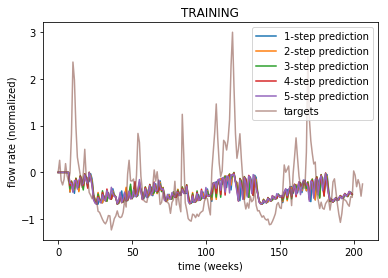

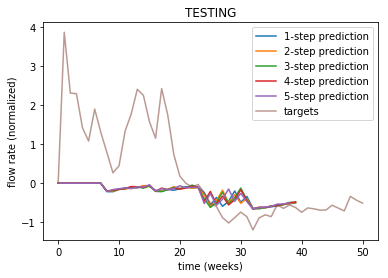

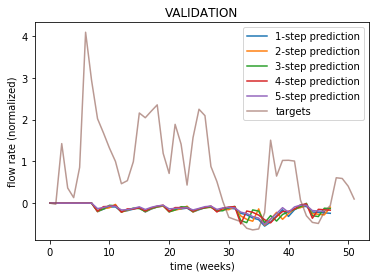

Figures saved to: .\./logs/multi-step/20180725-185453/IMG


In [17]:
# TRAINING THE NETWORK

# initializer of TF variables
init = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# define unique name for log directory (one-step and multi-step are in sepparate directories)
now = datetime.now()
if par.pred_step > 1:
    logdir = "./logs/multi-step/" + now.strftime("%Y%m%d-%H%M%S") + "/"
else:
    logdir = "./logs/one-step/" + now.strftime("%Y%m%d-%H%M%S") + "/"

print(now.strftime("%Y%m%d-%H%M%S"))

for repeat in range(par.n_repeats):
#    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    with tf.Session() as session:

        # take note of time at the start of training
        time_train_start = time.time()
        
        # initialize helping variables
        stop_training = False
        best_epoch = par.n_epochs
        
        # reset instance variables
        early_stopping.best_loss = 10000
        early_stopping.best_epoch = 0

        # Restore variables from disk if continueLearning is True.
        if continueLearning:
            # restoring variables will also initialize them
            saver.restore(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow')
            print("Model restored.")
        else:
            session.run(init) # initialize variables


        # Create a SummaryWriter to output summaries and the Graph
        # in console run 'tensorboard --logdir=./logs/'
        summary_logdir = logdir + "/" + str(repeat)
        summary_writer = tf.summary.FileWriter(logdir=summary_logdir, graph=session.graph)

        for epoch in range(par.n_epochs):
            # TRAINING
            loss_val, error_val, _ = run_model(x_train,y_train,par.train_batch_size,save=False,train=True)

            # TESTING
            loss_val_test, error_val_test, _ = run_model(x_test,y_test,par.test_batch_size,save=False,train=False)

            # write the summaries of testing data at epoch in TensorBoard
    #        summary_writer.add_summary(summary_test, epoch)

            # increment global step for decaying learning rate at each epoch
            session.run(increment_global_step_op)

            # Printing the results at every "par.n_epochs//10" epochs
            if epoch % (par.n_epochs//10) == 0:
                print("Epoch: {}".format(epoch))
                print("TRAINING Loss: {}".format(loss_val))
                print("TRAINING Error: {}".format(error_val))
                print("TESTING Loss: {}".format(loss_val_test))
                print("TESTING Error: {}".format(error_val_test))
                # flush the summary data into TensorBoard
                # summary_writer.flush()

            # Checking the model loss_value for early stopping each "check_every" epochs
            # save the trained net and variables for later use if the test loss_val is better than the last saved one
            best_loss, best_epoch, stop_training = early_stopping(loss_val_test,epoch,par.stop_epochs,par.check_every)

            # Stop the training process
            if stop_training:
                print("The training process stopped prematurely at epoch {}.".format(epoch))
                break
                
        # take note of time at the end of training
        time_train_end = time.time()
        
        # print training time per epoch
        time_train = time_train_end - time_train_start
        print("The training took {} seconds.".format(time_train))
        print("Average {} seconds/epoch".format(time_train/epoch))


    # Restoring the model coefficients with best results
    with tf.Session() as session:

        # restore the net coefficients with the lowest loss value
        saver.restore(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow')
        print('Restored model coefficients at epoch {} with TESTING loss val: {:.4f}'.format(best_epoch, best_loss))

        # run the trained net with best coefficients on all time-series and save the results
        loss_val, error_val, prediction_list = run_model(x_train,y_train,par.train_batch_size,save=True,train=False)
        loss_val_test, error_val_test, prediction_list_test = run_model(x_test,y_test,par.test_batch_size,save=True,train=False)
        loss_val_validation, error_val_validation, prediction_list_validation = run_model(x_validation,y_validation,par.val_batch_size,save=True,train=False)
    

    # printing parameters and results to console
    results = '''Timestamp: {}
_____________________________________________
Net parameters:
{}
_____________________________________________
Results: \n
Best epoch ...................... {:4d}
TRAINING Loss ................... {:11.6f}
TRAINING Error .................. {:11.6f}
TESTING Loss .................... {:11.6f}
TESTING Error ................... {:11.6f}
VALIDATION Loss ................. {:11.6f}
VALIDATION Error ................ {:11.6f}
_____________________________________________'''.format(now.strftime("%Y%m%d-%H%M%S")
                                                       ,par
                                                       ,best_epoch
                                                       ,loss_val
                                                       ,error_val
                                                       ,loss_val_test
                                                       ,error_val_test
                                                       ,loss_val_validation
                                                       ,error_val_validation)

    print(results)


    # saving results to log file in logdir
    file = "{}log{}.txt".format(logdir,repeat)
    with open(file, mode='w') as f:
        f.write(results)

    # Shift the predictions "par.delay" time-steps to the right
    prediction_train = np.array(prediction_list)
    prediction_test = np.array(prediction_list_test)
    prediction_validation = np.array(prediction_list_validation)

    def denormalize(labels):
        """
        Denormalize target values from interval (-1,1) to original values

        :param labels: values of labels to be denormalized
        :return: denormalized values of labels
        """

        # denormalized_labels = min_data + labels*(max_data - min_data)
        # denormalize the labels from (-1,1)
        denormalized_labels = mean_data + labels*std_data

        return denormalized_labels

    y_train_denorm = denormalize(y_train)
    y_test_denorm = denormalize(y_test)
    y_validation_denorm = denormalize(y_validation)

    def split_by_pred_step(raw_predictions):
        """
        split the predictions to pred_step separate time-series

        :param raw_predictions: the resulting prediction values from the neural net
        :return: a list of pred_step time-series of i-step predictions
        """
        prediction_list = [raw_predictions[i::par.pred_step] for i in range(par.pred_step)]

        return prediction_list

    def pad_by_delay(ts_list):
        """
        pad the time series with delay zeroes at the beginning

        :param ts_list: the list of time series that are to be padded with zeroes
        :return: list of padded time-series
        """
        
        return [np.pad(time_series,pad_width=((par.delay,0))
                                  ,mode='constant',constant_values=0)
                for time_series in ts_list] # pad with "par.delay" zeros at the start of first dimension

    # Plot the results
    def plot_results(raw_predictions, targets, selected_data):
        """
        plot the predictions and target values to one figure

        :param raw_predictions: the resulting prediction values from the neural net
        :param targets: the actual values of the time series
        :param selected_data: selector of input data (1 == Elbe flow, 2 == Saugeen flow) 
        :return: plot of predictions and target values
        """
        
        prediction_list = split_by_pred_step(raw_predictions)  # split
        prediction_list = pad_by_delay(prediction_list)        # pad with zeroes
        
        for prediction in prediction_list:
            plt.plot(prediction)
        plt.plot(targets, alpha=0.6)
        
        leg = ['{}-step prediction'.format(i+1) for i in range(par.pred_step)]
        leg.append('targets')
        plt.legend(leg)
        if selected_data == 1:
            plt.xlabel('time (weeks)')
            plt.ylabel('flow rate (normalized)')
        elif selected_data == 2:
            plt.xlabel('time (days)')
            plt.ylabel('flow rate (unknown)')        
        plt.draw()

    f_training = plt.figure()
    plot_results(prediction_train[plot_start:plot_end], y_train_denorm[plot_start:plot_end], selected_data)
    plt.title('TRAINING')

    f_testing = plt.figure()
    plot_results(prediction_test[plot_start:plot_end], y_test_denorm[plot_start:plot_end], selected_data)
    plt.title('TESTING')

    f_validation = plt.figure()
    plot_results(prediction_validation[plot_start:plot_end], y_validation_denorm[plot_start:plot_end], selected_data)
    plt.title('VALIDATION')
    plt.show()

    # Save the figures:
    img_save_dir = "{}IMG".format(logdir)
    save_dir_path = os.path.join(os.curdir, img_save_dir)
    os.makedirs(save_dir_path, exist_ok=True)

    f_training.savefig(save_dir_path + "/training{}.pdf".format(repeat), bbox_inches='tight')
    f_testing.savefig(save_dir_path + "/testing{}.pdf".format(repeat), bbox_inches='tight')
    f_validation.savefig(save_dir_path + "/validation{}.pdf".format(repeat), bbox_inches='tight')

    print("Figures saved to: {}".format(save_dir_path))

## Following cells are for debugging purposes

### TODO:
 - Variable length last batch to make use of all the available data!!!
 - plot every par.n_epochs//10 into tensorboard (different charts?)
 - try chaning par.hidden_size --- DONE
 - try chaning par.delay
 - try chaning par.n_lstm_layers
 - regularization (not necessarry)


 - test and validation --- DONE
 - drift??? --- DONE
 - Show the graph in TensorBoard -- DONE
 - add Dropout layer -- DONE
 - divide loss sum by n_iter to make it a loss val mean !!! --- DONE
 - add relative error between the predictions and targets --- DONE

#### Hyperparameter tuning
 - smaller batch size is better because you have to predict less things before updating weights
   but makes the training values more unstable
 - more prediction steps are worse
 - bigger delay?
 - number of stacked layers? - two is enough
 - smaller hidden size => faster, easier learning, less overfitting

In [18]:
print(prediction_train)

[-4.20957983e-01 -4.18178618e-01 -3.55429351e-01 -2.82428563e-01
 -2.27897435e-01 -1.96590871e-01 -1.82732806e-01 -1.87968567e-01
 -2.08264887e-01 -2.36675248e-01 -2.71606922e-01 -3.27690303e-01
 -3.77113760e-01 -4.02859747e-01 -4.26623344e-01 -4.47401106e-01
 -3.68810594e-01 -3.45939159e-01 -2.50617027e-01 -1.77193165e-01
 -1.39114305e-01 -1.24096140e-01 -1.25508502e-01 -1.43581629e-01
 -1.73641160e-01 -2.01247811e-01 -2.20237240e-01 -2.72564650e-01
 -3.23025286e-01 -3.56541514e-01 -3.86550367e-01 -4.12326097e-01
 -3.20722044e-01 -2.83938587e-01 -1.67531550e-01 -9.85398367e-02
 -7.48152211e-02 -7.14917630e-02 -8.34630802e-02 -1.09808527e-01
 -1.45217970e-01 -1.70606226e-01 -1.76588908e-01 -2.24636033e-01
 -2.74644434e-01 -3.12958539e-01 -3.46565425e-01 -3.75152647e-01
 -2.77054667e-01 -2.31701344e-01 -1.04032353e-01 -4.11847197e-02
 -2.87032314e-02 -3.34946252e-02 -5.24534062e-02 -8.36727098e-02
 -1.21228553e-01 -1.43605337e-01 -1.39659241e-01 -1.83051214e-01
 -2.31692672e-01 -2.72426

In [19]:
best_loss

0.846186637878418

In [20]:
best_epoch

30

In [21]:
prediction_validation

array([-0.20627648, -0.20409875, -0.19015892, -0.19180237, -0.13283919,
       -0.14298964, -0.13179392, -0.1427054 , -0.08482051, -0.10450083,
       -0.09455377, -0.11160465, -0.05250684, -0.0790193 , -0.06997328,
       -0.09115878, -0.03136211, -0.0627228 , -0.05429747, -0.07808605,
       -0.2022086 , -0.21649303, -0.21271665, -0.21624124, -0.16385308,
       -0.1817678 , -0.17187957, -0.162353  , -0.13879389, -0.15890543,
       -0.1450638 , -0.12872799, -0.12203337, -0.14310275, -0.12618604,
       -0.10563371, -0.11086033, -0.13192098, -0.11253882, -0.08963342,
       -0.21250604, -0.20635739, -0.20009707, -0.18656904, -0.15285677,
       -0.14230736, -0.13458268, -0.12914048, -0.11524049, -0.10213023,
       -0.09410866, -0.09238193, -0.08971201, -0.07519574, -0.06732001,
       -0.06811354, -0.07248978, -0.05747259, -0.05012965, -0.05261481,
       -0.18567991, -0.20437014, -0.21211505, -0.20300733, -0.13834524,
       -0.15538315, -0.16717035, -0.16389894, -0.10764489, -0.12

In [22]:
x = np.random.rand(10)

print(x)

mov_avg = 0

for i in range(len(x)):
    mov_avg = (mov_avg + x[i])/(i+1)
    
error = np.sum(x)/len(x)

print(mov_avg, error)

[0.93045239 0.45697805 0.75837636 0.00859111 0.51780424 0.37394295
 0.27151803 0.39326325 0.34363134 0.58013198]
0.06244800067183537 0.463468969892431
